In [12]:
# %load_ext line_profiler
%load_ext autoreload
%autoreload 2

from segmentation.util.utils_pipeline import segment_video_using_config_2d
from DLC_for_WBFM.utils.projects.utils_project import load_config, safe_cd
from pathlib import Path
import zarr
import os
import numpy as np
import napari
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import get_single_volume

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# project_fname = r'Y:\shared_projects\wbfm\dlc_stacks\Charlie-immobilized-long\project_config.yaml'
# project_fname = r'Y:\shared_projects\wbfm\dlc_stacks\Charlie-immobilized-2021_05_11\project_config.yaml'
project_fname = r"C:\dlc_stacks\Test_project\project_config.yaml"

project_cfg = load_config(project_fname)
segment_fname = project_cfg['subfolder_configs']['segmentation']
project_dir = Path(project_fname).parent
with safe_cd(project_dir):
    segment_cfg = load_config(segment_fname)

this_config = segment_cfg.copy()
this_config['dataset_params'] = project_cfg['dataset_params'].copy()

red_data_fname = project_cfg['preprocessed_red']

red = zarr.open(red_data_fname)

In [15]:
with safe_cd(project_dir):
    fname = segment_cfg['output_masks']
    z = zarr.open(fname)

In [16]:
viewer = napari.view_labels(z)

vispy_camera.py (109): divide by zero encountered in true_divide


## View original

In [13]:
mask0_raw = np.array(z[0,...])
dat0_raw = get_single_volume(red_data_fname, 0, 33, dtype='uint16')

In [49]:
viewer = napari.view_labels(mask0_raw)
viewer.add_image(dat0_raw)

<Image layer 'dat0_raw' at 0x21ca6b7c688>

## Remove globally dim pixels and re-stitch

In [9]:
from segmentation.util.utils_postprocessing import *

In [46]:
background = 2 * np.mean(dat0_raw)
print(f"Background measured as: {background}")
dim_pixels = dat0_raw < background

mask0_dim_removed = mask0_raw.copy()
mask0_dim_removed[dim_pixels] = 0

Background measured as: 233.30953810953812


In [91]:
viewer = napari.view_labels(mask0_raw)
viewer.add_labels(mask0_dim_removed)
# viewer.add_image(dat0_raw)

<Labels layer 'mask0_dim_removed' at 0x21ca9300588>

## 3d stardist

In [81]:
from segmentation.util.utils_model import segment_with_stardist_3d
from segmentation.util.utils_model import get_stardist_model
from csbdeep.utils import Path, normalize

model_name = 'charlie_3d'
sd_model = get_stardist_model(model_name, verbose=2)

Getting Stardist model: charlie_3d
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.353429, nms_thresh=0.3.


In [82]:
def _segment3d(dat, model, prob_thresh=0.5):
    # From: segment_with_stardist_3d
    
    # initialize variables
    axis_norm = (0, 1, 2)
    n_channel = 1

    # normalizing images (stardist function)
    img = normalize(dat, 1, 99.8, axis=axis_norm)

    # run the prediction
    labels, details = model.predict_instances(img, prob_thresh=prob_thresh)
    
    print("Finished")
    return labels

In [83]:
mask0_3d = _segment3d(dat0_raw, sd_model, prob_thresh=None)

Finished


In [90]:
viewer = napari.view_labels(mask0_3d)
# viewer.add_image(dat0_raw)

In [ ]:
# sd_model.predict_instances()

# Look at the segmentation metadata

In [4]:
import pickle

In [5]:
fname = r"C:\dlc_stacks\Test_project\1-segmentation\metadata_3.pickle"
with open(fname, 'rb') as f:
    dat = pickle.load(f)

In [8]:
dat[1]

,total_brightness,neuron_volume,centroids,all_values
1,53231,1007,"(5.734856007944389, 261.28103277060575, 408.89...","[25, 26, 26, 25, 26, 26, 28, 30, 29, 28, 27, 2..."
2,54561,1111,"(4.923492349234923, 279.96129612961295, 407.92...","[25, 24, 24, 24, 24, 29, 29, 27, 27, 23, 24, 2..."
4,45378,1047,"(5.204393505253104, 303.31232091690543, 395.39...","[25, 25, 30, 27, 27, 28, 29, 29, 27, 27, 28, 2..."
5,17120,486,"(3.5102880658436213, 298.3168724279835, 412.98...","[20, 21, 21, 20, 20, 19, 22, 23, 23, 25, 24, 2..."
6,8518,220,"(3.4045454545454548, 106.24545454545455, 714.7...","[28, 31, 32, 27, 28, 33, 39, 39, 40, 37, 30, 2..."
...,...,...,...,...
166,90673,2690,"(18.596654275092938, 265.8171003717472, 468.32...","[18, 20, 21, 22, 23, 26, 28, 29, 29, 21, 20, 2..."
167,87521,1491,"(18.41649899396378, 239.6056338028169, 401.817...","[26, 29, 26, 29, 29, 29, 31, 30, 34, 34, 34, 3..."
168,55936,1249,"(19.518014411529222, 254.06725380304243, 275.9...","[22, 24, 27, 24, 24, 28, 32, 26, 26, 31, 34, 2..."
169,28704,869,"(17.743383199079403, 222.409666283084, 331.594...","[19, 20, 20, 18, 19, 21, 20, 21, 20, 19, 18, 1..."


In [9]:
dat[0]

,total_brightness,neuron_volume,centroids,all_values
1,55865,991,"(4.9212916246215945, 297.89404641775985, 424.0...","[24, 24, 21, 22, 25, 25, 26, 27, 24, 23, 25, 2..."
2,51494,960,"(5.907291666666667, 279.96458333333334, 418.15)","[22, 21, 23, 22, 22, 23, 24, 24, 22, 24, 22, 1..."
3,17623,477,"(4.517819706498952, 313.251572327044, 433.0775...","[20, 23, 24, 25, 21, 23, 27, 28, 27, 26, 25, 2..."
4,38043,682,"(5.4340175953079175, 324.3123167155425, 419.81...","[25, 25, 22, 26, 26, 28, 26, 27, 22, 24, 25, 2..."
5,40658,819,"(6.617826617826617, 333.7435897435897, 426.553...","[21, 21, 22, 23, 21, 20, 23, 26, 24, 26, 23, 2..."
...,...,...,...,...
146,83620,2207,"(19.604893520616223, 265.806524694155, 477.065...","[27, 28, 31, 26, 29, 29, 30, 29, 24, 27, 25, 3..."
147,84275,1377,"(19.531590413943356, 265.6608569353667, 407.95...","[36, 28, 34, 42, 51, 52, 28, 35, 43, 50, 61, 6..."
148,27954,758,"(18.811345646437996, 266.29947229551453, 338.4...","[20, 21, 24, 22, 20, 23, 25, 26, 25, 21, 23, 2..."
149,55272,1241,"(19.381144238517326, 327.7655116841257, 353.49...","[30, 31, 33, 27, 29, 24, 28, 29, 30, 28, 24, 3..."


# Remove small objects

In [28]:
import skimage
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max


In [34]:
z_raw = np.array(z[1,...])
red_raw = np.array(red[1,...])

z2 = skimage.morphology.remove_small_objects(z_raw, 30)
z_binary = skimage.morphology.remove_small_holes(z2.astype(bool), 10)
z_distance = ndi.distance_transform_edt(z_binary)
z_dist_times_brightness = z_distance*red_raw

coords = peak_local_max(z_dist_times_brightness, footprint=np.ones((5, 11, 11)), labels=z_binary)
mask = np.zeros(z_distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

print("Resegmenting using watershed...")
labels = watershed(-z_dist_times_brightness, markers, mask=z_binary)

Resegmenting using watershed...


In [36]:
v = napari.view_labels(labels)
v.add_labels(z_raw)

vispy_camera.py (109): divide by zero encountered in true_divide


<Labels layer 'z_raw' at 0x291ac3496c8>

In [31]:
v = napari.view_labels(z2)


vispy_camera.py (109): divide by zero encountered in true_divide


# Combine basic local thresholding

In [39]:
from skimage.filters import threshold_otsu, threshold_local
from magicgui import magicgui
from napari.types import LayerDataTuple

In [44]:
z_raw = np.array(z[1,...])
red_raw = np.array(red[1,...])

In [52]:
# TAKES A VERY LONG TIME

# @magicgui(
#     call_button="Apply local threshold")
# def apply_distance_transform(viewer: napari.Viewer, sigma=1, offset=10,block_size=35) -> LayerDataTuple:
#     red_dat = viewer.layers['red_dat'].data[0,...]
    
#     # Filter the brightness
#     filtered_red = skimage.filters.gaussian(red_dat, sigma=sigma)
    
#     print("Doing local threshold...")
#     local_thresh = threshold_local(image, block_size, offset=offset, method='mean')
#     binary_local = image > local_thresh
#     print("Finished")
    
#     return [(binary_local, {'name': 'binary_local'}, 'labels'), 
#             (filtered_red, {'name': 'filtered_red'}, 'image')]

In [53]:
viewer = napari.view_image(red_raw, name='red_dat')
viewer.add_labels(z_raw, name="seg_dat")

vispy_camera.py (109): divide by zero encountered in true_divide


<Labels layer 'seg_dat' at 0x291a9daaf48>

In [54]:
viewer.window.add_dock_widget(apply_distance_transform)

Doing local threshold...


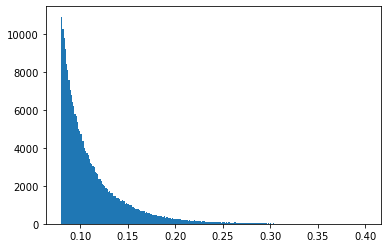

In [72]:
import matplotlib.pyplot as plt
filtered_red = skimage.filters.gaussian(red_raw, sigma=2)
thresh = 0.08

plt.hist(filtered_red[filtered_red>thresh], bins=255);

In [69]:
np.mean(filtered_red)

0.05751434748173632